Opening tile number  0  of  4
Opening tile number  1  of  4
Opening tile number  2  of  4
Opening tile number  3  of  4
Done.
Merging ... 
Done.


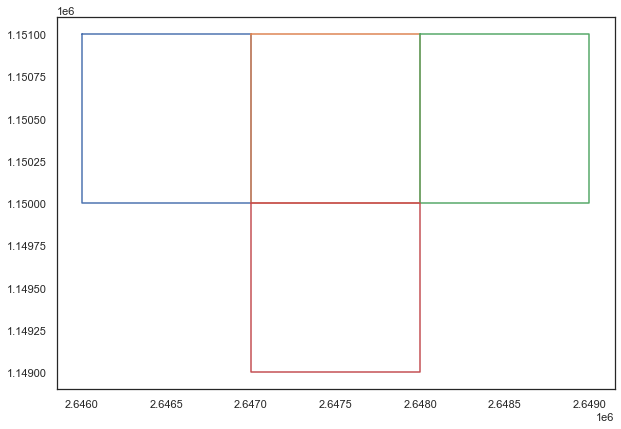

In [1]:
from utils import *
# from raster_utils import *
import matplotlib.pyplot as plt
from plot_utils import *
gps_coords = 46.500458, 8.052669
gps_lat, gps_lon = gps_coords


metadata_links = {'2m' : 'ch.swisstopo.swissalti3d-fGQ3d2A6.csv' , \
                '0.5m' : 'https://ogd.swisstopo.admin.ch/resources/ch.swisstopo.swissalti3d-3TuKAiHo.csv' }

transformer = Transformer.from_crs( 'epsg:4326', 'epsg:2056' )
swiss_topo_lon, swiss_topo_lat = transformer.transform( gps_lat, gps_lon)

filename = metadata_links['2m']
global grid_size 
grid_size = 2
radius = 1
tile_meta_df = get_tile_metadata(filename)
target_tiles = get_targets(swiss_topo_lat, swiss_topo_lon, tile_meta_df, radius)
plot_tile_corners(target_tiles)

array, blank_array, transform = get_tiles(target_tiles, source = 'local')

observer_pixel, observer_height = get_observer_position(array, blank_array, swiss_topo_lat, swiss_topo_lon )
peaks_df = get_peaks( array, observer_pixel, observer_height, grid_size)

array =  np.squeeze(array, axis = 0)


# mdf_list, tdf_list, amdf_list = [], [], []
# for month in np.arange(1,2):
#     # compile data for a range of months
#     year = 2021
#     day = 1
#     date = {'year':year,'month':month,'day':day}
#     start_date = datetime.date(year = date['year'], month = date['month'], day = date['day'])
#     mdf_,tdf_,amdf_  = get_data(gps_coords, observer_height, peaks_df, start_date)
#     mdf_list.append(mdf_)
#     tdf_list.append(tdf_)
#     amdf_list.append(amdf_)

# mdf = mdf_list[0]

In [49]:
target_tiles['source'] = target_tiles['local_tile']
src_list = []
for i, tile_path in enumerate( target_tiles.source ):
    print('Opening tile number ', i, ' of ', target_tiles.source.size)
    src_list.append(rio.open(tile_path, mode='r'))
print('Done.')
print('Merging ... ')
array, transform = rio.merge.merge(src_list )
print('Done.')
src = src_list[0]
blank_array = rio.open( \
    '/tmp/new.tif', \
    'w', \
    driver='GTiff', \
    height=array.shape[1], \
    width=array.shape[2], \
    count=1, \
    crs=src_list[0].crs, \
    transform=transform, \
    dtype = array.dtype)

out_meta = src_list[0].meta.copy() # Copy the metadata
# Update the metadata
out_meta.update({"driver": "GTiff",
                "height": array.shape[1],
                "width": array.shape[2],
                "transform": transform,
                "crs": src_list[0].crs,                    
                }
                )
# Plot the result
# show(mosaic, cmap='terrain')
# Write the mosaic raster to disk
raster_name = './outteer.tiff'
with rio.open(raster_name, "w", **out_meta) as dest:
    dest.write(array)

Opening tile number  0  of  4
Opening tile number  1  of  4
Opening tile number  2  of  4
Opening tile number  3  of  4
Done.
Merging ... 
Done.


In [51]:
dataset = rio.open('/Users/george-birchenough/solmap/outteer.tiff', mode='r')
dataset.bounds

BoundingBox(left=2646000.0, bottom=1149000.0, right=2649000.0, top=1151000.0)

In [20]:
observer_pixel, observer_height = get_observer_position(array, blank_array, swiss_topo_lat, swiss_topo_lon )

In [27]:
blank_array.shape
array.shape

(1, 1000, 1500)

In [45]:
# array =  np.squeeze(array, axis = 0)

from rasterio.warp import reproject, Resampling
newarray = np.empty(shape = array.shape)
reproject(
    source = array,
    destination = newarray,
    src_transform = transform,
    dst_transform = transform,
    src_crs = blank_array.crs,
    dst_crs=blank_array.crs
)

(array([[[ 2716.4909668 ,  2716.40063477,  2716.40917969, ...,
           3073.40551758,  3073.77050781,  3074.07128906],
         [ 2716.23339844,  2716.21728516,  2716.31274414, ...,
           3073.36816406,  3073.91992188,  3074.07055664],
         [ 2716.04492188,  2715.97363281,  2715.95507812, ...,
           3073.51367188,  3073.87792969,  3074.41674805],
         ...,
         [-9999.        , -9999.        , -9999.        , ...,
          -9999.        , -9999.        , -9999.        ],
         [-9999.        , -9999.        , -9999.        , ...,
          -9999.        , -9999.        , -9999.        ],
         [-9999.        , -9999.        , -9999.        , ...,
          -9999.        , -9999.        , -9999.        ]]]),
 Affine(2.0, 0.0, 2646000.0,
        0.0, -2.0, 1151000.0))

In [48]:
with blank_array as dataset:
    


AttributeError: 'numpy.ndarray' object has no attribute 'bounds'

In [ ]:
array.crs

AttributeError: 'tuple' object has no attribute 'crs'

In [ ]:
array.shape

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data1.csv')
dff = df.query('Lat < 40.82').query('Lat > 40.70').query('Lon > -74.02').query('Lon < -73.91')
dff

In [ ]:

import datashader as ds
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(dff, x='Lon', y='Lat')
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = agg.coords['Lat'].values, agg.coords['Lon'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

from colorcet import fire
import datashader.transfer_functions as tf
img = tf.shade(agg, cmap=fire)[::-1].to_pil()

import plotly.express as px
# Trick to create rapidly a figure with mapbox axes
fig = px.scatter_mapbox(dff[:1], lat='Lat', lon='Lon', zoom=12)
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()